# 1. Resources

In [1]:
# Essentials
import pickle
import random
import os
import math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

# PyTorch
import torch
import torchvision
import torch.nn as nn  
import torch.nn.functional as F
import torchvision.transforms.functional as tvf
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [32]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## ContrastiveLoss

In [3]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

## Image augmentations

In [4]:
# def random_rotate(image):
#     if random.random() > 0.5:
#         return F.rotate(image, angle=random.choice((0, 90, 180, 270)))
#     return image

In [5]:
class ResizedRotation():
    def __init__(self, angle, output_size=(96, 96)):
        self.angle = angle
        self.output_size = output_size
        
    def angle_to_rad(self, ang): return np.pi * ang / 180.0
        
    def __call__(self, image):
        w, h = image.shape[1,2]
        new_h = int(np.abs(w * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(h * np.sin(self.angle_to_rad(self.angle))))
        new_w = int(np.abs(h * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(w * np.sin(self.angle_to_rad(self.angle))))
        img = tvf.resize(image, (new_w, new_h))
        img = tvf.rotate(img, self.angle)
        img = tvf.center_crop(img, self.output_size)
        return img

In [6]:
class WrapWithRandomParams():
    def __init__(self, constructor, ranges):
        self.constructor = constructor
        self.ranges = ranges
    
    def __call__(self, image):
        randoms = [float(np.random.uniform(low, high)) for _, (low, high) in zip(range(len(self.ranges)), self.ranges)]
        return self.constructor(*randoms)(image)

In [25]:
np.random.uniform(0,1)

0.889868971092916

In [18]:
ranges = [(0.0, 360.0)]

In [24]:
len(ranges)

1

In [23]:
range(len(ranges))

range(0, 1)

In [21]:
for _, (low, high) in zip(range(len(ranges)), ranges):
    print(_, low, high)

0 0.0 360.0


In [7]:
random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle), [(0.0, 360.0)])

# 2. Dataset and dataloader

In [8]:
# Directories
data_dir = "/storage/intern"
label_path = "./mat/MatLB3"
params_path = "./model/model_params"
experiment = "mat"
# Define parameter
batch_size = 128
num_workers = 2

In [31]:
# Imagenet normalization
in_mean = [0.485, 0.456, 0.406]
in_std = [0.229, 0.224, 0.225]

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(128),
        transforms.RandomRotation(360),
        transforms.CenterCrop(96),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    "val": transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(96),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [33]:
# Dataset
train_set = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
val_set = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])

In [34]:
# Loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [13]:
idx = 123

In [28]:
img_sample = tvf.resize(train_set[idx][0], (96, 96))
x, y = img_sample.shape[1,2]
print(x, y)

TypeError: tuple indices must be integers or slices, not tuple

In [29]:
img_sample.shape

torch.Size([3, 96, 96])

In [26]:
img_sample.size

<function Tensor.size>

In [17]:
# Visualiaztion
random_resized_rotation(img_sample)

TypeError: cannot unpack non-iterable builtin_function_or_method object

Dataset characteristic

In [ ]:
train_size = len(train_set)
val_size = len(val_set)
num_batches = math.floor(train_size/batch_size)
print(f"Train dataset: {train_size}")
print(f"Val dataset: {val_size}")
print(f"Number of batches: {num_batches}")

In [ ]:
label_names = train_set.classes
num_class = len(label_names)
print(f"Number of classes: {num_class}")
print(label_names)

Number of classes: 31
['calf', 'canvas', 'canvas+leather', 'coatedcanvas', 'crocodile', 'denim', 'enamel', 'flora canvas', 'fur', 'gg crystal', 'gg embossed leather', 'gg imprime ', 'gg nylon', 'gg plus', 'gg supreme canvas', 'ggcanvas', 'guccissima', 'guccissima nylon', 'jacquard ', 'leather', 'linen', 'lizard', 'microguccissima', 'nylon', 'ostrich', 'pig', 'python', 'quilted leather', 'suede', 'velor', 'velvet']


In [ ]:
# Pickle class_name
f = open(label_path, "wb")
f.write(pickle.dumps(label_names))
f.close()

## Visualize the data

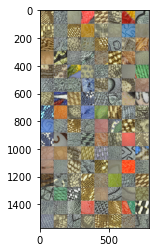

NameError: name 'label_names' is not defined

In [35]:
# Plot some training images
images, labels = next(iter(train_loader))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{label_names[labels[j]]:5s}' for j in range(batch_size)))

# 3. Model

Create the base model from the pre-trained EfficientNetB0

In [ ]:
# Model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
in_fc = model.classifier.fc.in_features
model.classifier.fc = nn.Linear(in_fc, num_class)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train

In [ ]:
num_epochs = 5
learning_rate = 0.01

In [ ]:
losses = []
accuracies = []

torch.cuda.empty_cache()

# Initialize network
model.to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Progress bar
outer = tqdm(total=num_epochs+1, unit="epochs", position=0, desc="Epoch")

# Train
epoch_dict = {}
step = 0
for epoch in range(num_epochs):
    inner = tqdm(total=num_batches+1, unit="batches", position=1, desc="Batch")
    batch_log = tqdm(total=0, position=2, bar_format='{desc}')
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)                          # N, C, W, H
        labels = labels.to(device)                          # N

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predictions = outputs.max(1)                     # N
        step_accuracy = (predictions == labels).sum() / inputs.shape[0]
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step += 1        
        
        # Output training stats
        if batch_idx % 50 == 0:
            print("[%d/%d][%d/%d]\tLoss: %.4f\tAccuracy: %.4f"
                  % (epoch, num_epochs, batch_idx, len(train_loader),
                     loss.item(), step_accuracy))
        # Save Losses for plotting later
        losses.append(loss.item())
        accuracies.append(step_accuracy)
        
        # Update progression bar
        batch_log.set_description_str(f"loss: {round(loss.item(), 4)}, accuracy: {step_accuracy}")
        inner.update(1)
    outer.update(1)

print("Training completed.")
        

Epoch:   0%|          | 0/5 [00:00<?, ?epochs/s]

Batch:   0%|          | 0/808 [00:00<?, ?batches/s]

[0/5][0/809]	Loss: 3.3876	Accuracy: 0.0781
[0/5][50/809]	Loss: 1.2204	Accuracy: 0.6094
[0/5][100/809]	Loss: 1.0117	Accuracy: 0.6719
[0/5][150/809]	Loss: 0.8710	Accuracy: 0.7812
[0/5][200/809]	Loss: 0.8796	Accuracy: 0.7969
[0/5][250/809]	Loss: 0.7699	Accuracy: 0.7500
[0/5][300/809]	Loss: 0.7338	Accuracy: 0.7656
[0/5][350/809]	Loss: 0.5225	Accuracy: 0.8438
[0/5][400/809]	Loss: 0.8980	Accuracy: 0.7188
[0/5][450/809]	Loss: 0.8262	Accuracy: 0.7656
[0/5][500/809]	Loss: 0.9077	Accuracy: 0.7344
[0/5][550/809]	Loss: 0.7624	Accuracy: 0.7188
[0/5][600/809]	Loss: 0.5580	Accuracy: 0.7812
[0/5][650/809]	Loss: 0.6733	Accuracy: 0.7812
[0/5][700/809]	Loss: 0.5175	Accuracy: 0.8438
[0/5][750/809]	Loss: 0.5158	Accuracy: 0.8438
[0/5][800/809]	Loss: 0.6272	Accuracy: 0.8281


Batch:   0%|          | 0/808 [00:00<?, ?batches/s]

[1/5][0/809]	Loss: 0.5379	Accuracy: 0.7812
[1/5][50/809]	Loss: 0.5763	Accuracy: 0.8281
[1/5][100/809]	Loss: 0.3999	Accuracy: 0.9062
[1/5][150/809]	Loss: 0.5550	Accuracy: 0.8281
[1/5][200/809]	Loss: 0.4261	Accuracy: 0.8594
[1/5][250/809]	Loss: 0.5392	Accuracy: 0.7812
[1/5][300/809]	Loss: 0.2741	Accuracy: 0.8750
[1/5][350/809]	Loss: 0.4523	Accuracy: 0.8906
[1/5][400/809]	Loss: 0.4081	Accuracy: 0.8438
[1/5][450/809]	Loss: 0.3048	Accuracy: 0.9062
[1/5][500/809]	Loss: 0.3840	Accuracy: 0.9062
[1/5][550/809]	Loss: 0.3948	Accuracy: 0.8438
[1/5][600/809]	Loss: 0.4712	Accuracy: 0.8594
[1/5][650/809]	Loss: 0.2160	Accuracy: 0.9531
[1/5][700/809]	Loss: 0.3537	Accuracy: 0.8438
[1/5][750/809]	Loss: 0.4427	Accuracy: 0.7969
[1/5][800/809]	Loss: 0.4587	Accuracy: 0.8438


Batch:   0%|          | 0/808 [00:00<?, ?batches/s]

[2/5][0/809]	Loss: 0.2144	Accuracy: 0.8906
[2/5][50/809]	Loss: 0.2995	Accuracy: 0.9219
[2/5][100/809]	Loss: 0.3977	Accuracy: 0.8438
[2/5][150/809]	Loss: 0.1783	Accuracy: 0.9375
[2/5][200/809]	Loss: 0.1729	Accuracy: 0.9375
[2/5][250/809]	Loss: 0.4036	Accuracy: 0.8906
[2/5][300/809]	Loss: 0.2068	Accuracy: 0.9219
[2/5][350/809]	Loss: 0.5074	Accuracy: 0.8281
[2/5][400/809]	Loss: 0.2352	Accuracy: 0.9062
[2/5][450/809]	Loss: 0.3707	Accuracy: 0.7969
[2/5][500/809]	Loss: 0.4024	Accuracy: 0.8594
[2/5][550/809]	Loss: 0.2256	Accuracy: 0.8906
[2/5][600/809]	Loss: 0.3313	Accuracy: 0.9062
[2/5][650/809]	Loss: 0.2678	Accuracy: 0.9062
[2/5][700/809]	Loss: 0.3388	Accuracy: 0.8594
[2/5][750/809]	Loss: 0.2836	Accuracy: 0.8906
[2/5][800/809]	Loss: 0.4190	Accuracy: 0.8750


Batch:   0%|          | 0/808 [00:00<?, ?batches/s]

[3/5][0/809]	Loss: 0.2958	Accuracy: 0.8438
[3/5][50/809]	Loss: 0.1725	Accuracy: 0.9375
[3/5][100/809]	Loss: 0.3270	Accuracy: 0.8594
[3/5][150/809]	Loss: 0.2618	Accuracy: 0.8906
[3/5][200/809]	Loss: 0.2609	Accuracy: 0.8906
[3/5][250/809]	Loss: 0.3621	Accuracy: 0.8906
[3/5][300/809]	Loss: 0.2217	Accuracy: 0.9375
[3/5][350/809]	Loss: 0.2725	Accuracy: 0.8906
[3/5][400/809]	Loss: 0.2505	Accuracy: 0.8906
[3/5][450/809]	Loss: 0.1971	Accuracy: 0.9688
[3/5][500/809]	Loss: 0.2183	Accuracy: 0.9531
[3/5][550/809]	Loss: 0.3399	Accuracy: 0.8594
[3/5][600/809]	Loss: 0.1896	Accuracy: 0.9219
[3/5][650/809]	Loss: 0.1474	Accuracy: 0.9531
[3/5][700/809]	Loss: 0.1882	Accuracy: 0.9375
[3/5][750/809]	Loss: 0.4339	Accuracy: 0.8750
[3/5][800/809]	Loss: 0.3424	Accuracy: 0.8750


Batch:   0%|          | 0/808 [00:00<?, ?batches/s]

[4/5][0/809]	Loss: 0.2002	Accuracy: 0.8906
[4/5][50/809]	Loss: 0.3058	Accuracy: 0.9219
[4/5][100/809]	Loss: 0.2618	Accuracy: 0.9219
[4/5][150/809]	Loss: 0.2598	Accuracy: 0.8906
[4/5][200/809]	Loss: 0.1747	Accuracy: 0.8750
[4/5][250/809]	Loss: 0.1866	Accuracy: 0.9375
[4/5][300/809]	Loss: 0.2268	Accuracy: 0.9375
[4/5][350/809]	Loss: 0.2009	Accuracy: 0.8906
[4/5][400/809]	Loss: 0.1240	Accuracy: 0.9531
[4/5][450/809]	Loss: 0.1101	Accuracy: 0.9531
[4/5][500/809]	Loss: 0.2404	Accuracy: 0.9062
[4/5][550/809]	Loss: 0.0896	Accuracy: 0.9844
[4/5][600/809]	Loss: 0.1558	Accuracy: 0.9375
[4/5][650/809]	Loss: 0.2587	Accuracy: 0.9062
[4/5][700/809]	Loss: 0.1002	Accuracy: 0.9688
[4/5][750/809]	Loss: 0.2359	Accuracy: 0.9062
[4/5][800/809]	Loss: 0.1271	Accuracy: 0.9375
Training completed.


In [ ]:
# Save model parameters
params_path = "./mat/params"
torch.save(model.state_dict(), params_path)

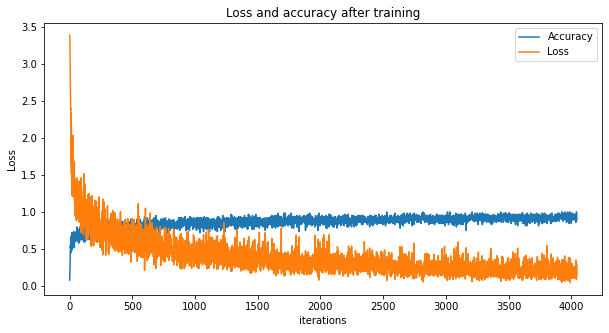

In [ ]:
# Plot
plt.figure(figsize=(10,5))
plt.title("Loss and accuracy after training")
plt.plot(accuracies,label="Accuracy")
plt.plot(losses,label="Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()